## Crash Course: Sequential Learning

First, we perform some standard imports.

In [1]:
# Standard packages
import os
import re
import functools

# Workshop-specific tools
from workshop_utils import pifs2df

# Scientific computation
import numpy as np
import pandas as pd

# Third-party packages
from citrination_client import CitrinationClient
from citrination_client import PifSystemReturningQuery, PifSystemQuery
from citrination_client import DataQuery, DatasetQuery, ChemicalFieldQuery
from citrination_client import PropertyQuery, FieldQuery
from citrination_client import ChemicalFilter, Filter

# For linear regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pypif import pif
from dfttopif import directory_to_pif
from pypif_sdk.readview import ReadView
import matplotlib.pyplot as plt
%matplotlib inline

Next we initialize the client.

In [2]:
site = 'https://citrination.com' # public
client = CitrinationClient(api_key=os.environ['CITRINATION_API_KEY'], site=site)
search_client = client.search

## Pull the data

In [3]:
# Change dataset id below
dataset_id = 150670
system_query = \
    PifSystemReturningQuery(
        size=500, 
        query=DataQuery(
            dataset=DatasetQuery(
                id=Filter(equal=str(dataset_id))
            )
        )
    )

query_result = search_client.pif_search(system_query)
print("Found {} PIFs in dataset {}.".format(query_result.total_num_hits, dataset_id))

Found 437 PIFs in dataset 150670.


In [4]:
pifs = [x.system for x in query_result.hits]
# Check that all pifs are same length
n_feat = [len(ReadView(pif).keys()) for pif in pifs]
print(all([n == min(n_feat) for n in n_feat]))
# Check that all pif keys are the same
keys_ref = set(ReadView(pifs[0]).keys())
print(all([keys_ref == set(ReadView(pif).keys()) for pif in pifs]))

True
True


In [5]:
# Rectangularize the data
# df_data = \
#     pd.DataFrame(
#         columns = keys_ref,
#         data = [
#             [
#                 float(ReadView(pif)[key].scalars[0].value) \
#                 for key in keys_ref
#             ] for pif in pifs
#         ]
# )
df_data = pifs2df(pifs)

In [6]:
df_data

,Diffusion Temperature,Carburization Temperature,Diffusion time,Fatigue Strength,Area Proportion of Inclusions Occurring in Discontinuous Array,Tempering Time,Tempering Temperature,Cooling Rate for Through Hardening,Through Hardening Temperature,Quenching Media Temperature (for Carburization),Cooling Rate for Tempering,Area Proportion of Inclusions Deformed by Plastic Work,Area Proportion of Isolated Inclusions,Normalizing Temperature,Carburization Time,Sample Number,Reduction Ratio (Ingot to Bar),Through Hardening Time
0,30.0,30.0,0.0,451.0,0.0,60.0,550.0,8.0,845.0,30.0,24.0,0.02,0.01,870.0,0.0,228.0,530.0,30.0
1,30.0,30.0,0.0,631.0,0.0,60.0,550.0,8.0,855.0,30.0,24.0,0.04,0.03,870.0,0.0,193.0,510.0,30.0
2,30.0,30.0,0.0,406.0,0.0,60.0,600.0,8.0,845.0,30.0,24.0,0.03,0.01,870.0,0.0,233.0,610.0,30.0
3,30.0,30.0,0.0,433.0,0.0,60.0,550.0,24.0,865.0,30.0,24.0,0.1,0.0,865.0,0.0,22.0,1740.0,30.0
4,30.0,30.0,0.0,385.0,0.0,60.0,650.0,8.0,845.0,30.0,24.0,0.03,0.01,870.0,0.0,240.0,610.0,30.0
5,30.0,30.0,0.0,394.0,0.01,60.0,600.0,24.0,865.0,30.0,24.0,0.06,0.01,865.0,0.0,29.0,610.0,30.0
6,30.0,30.0,0.0,465.0,0.0,60.0,550.0,24.0,845.0,30.0,24.0,0.04,0.03,845.0,0.0,54.0,610.0,30.0
7,30.0,30.0,0.0,550.0,0.0,60.0,600.0,8.0,855.0,30.0,24.0,0.02,0.01,870.0,0.0,157.0,740.0,30.0
8,30.0,30.0,0.0,770.0,0.0,60.0,500.0,8.0,845.0,30.0,24.0,0.07,0.01,845.0,0.0,377.0,1455.0,30.0
9,30.0,30.0,0.0,422.0,0.01,60.0,600.0,24.0,845.0,30.0,24.0,0.04,0.0,845.0,0.0,69.0,1270.0,30.0


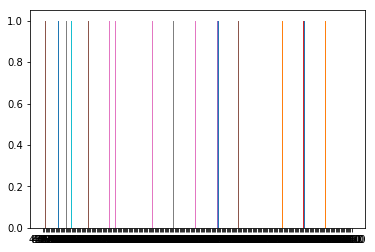

In [7]:
plt.figure()

plt.hist(
    df_data["Fatigue Strength"],
    bins = 15
)
plt.show()

## Featurize the formulae

First, let's read an example formula.

In [8]:
ReadView(pifs[0]).chemical_formula

'Fe0.9759C0.004Mn0.0156Cu0.0005Si0.0022P0.00011S0.00019Ni0.0006Cr0.0009'

It seems the formulae are given as Element identifiers followed by percentage values. We will have to separate every formula into iterables of (XX, p) pairs, and rectangularize on every possible entry of XX.

In [9]:
# Define a helper
def parse_formula(formula):
    composition = dict(map(
        lambda s: (
            re.search(r'\D+', s).group(),
            float(re.search(r'[\d\.]+', s).group())
        ),
        re.findall(
            r'\w+[\d\.]+',
            formula
            #ReadView(pifs[0]).chemical_formula
        )
    ))
    return composition
    
# Parse all the formulas
all_compositions = [
    parse_formula(ReadView(pif).chemical_formula) \
    for pif in pifs
]
all_formulas = [set(d.keys()) for d in all_compositions]

# Determine the superset of elements
all_elements = functools.reduce(
    lambda s1, s2: s1.union(s2),
    all_formulas
)

# Join all formulas
df_composition = pd.DataFrame(columns = all_elements)

for ind in range(len(all_compositions)):
    df_composition = df_composition.append(
        pd.DataFrame(
            columns = all_compositions[ind].keys(),
            data = [all_compositions[ind].values()]
        ),
        ignore_index = True
    )
df_composition = df_composition.fillna(0)

/Users/zdelrosario/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [10]:
df_composition

,C,Cr,Cu,Fe,Mn,Mo,Ni,P,S,Si
0,0.0040,0.0009,0.0005,0.97590,0.0156,0.0000,0.0006,0.00011,0.00019,0.0022
1,0.0040,0.0096,0.0010,0.97088,0.0074,0.0018,0.0024,0.00014,0.00028,0.0025
2,0.0038,0.0013,0.0007,0.97588,0.0152,0.0000,0.0003,0.00012,0.00000,0.0027
3,0.0037,0.0002,0.0002,0.98575,0.0072,0.0000,0.0002,0.00015,0.00020,0.0024
4,0.0038,0.0013,0.0007,0.97588,0.0152,0.0000,0.0003,0.00012,0.00000,0.0027
5,0.0038,0.0009,0.0011,0.98340,0.0070,0.0000,0.0006,0.00000,0.00030,0.0029
6,0.0047,0.0004,0.0004,0.98335,0.0072,0.0000,0.0013,0.00015,0.00000,0.0025
7,0.0036,0.0097,0.0012,0.97224,0.0074,0.0015,0.0005,0.00016,0.00020,0.0035
8,0.0061,0.0016,0.0012,0.96007,0.0086,0.0000,0.0016,0.00019,0.00014,0.0205
9,0.0042,0.0010,0.0000,0.98496,0.0070,0.0000,0.0000,0.00024,0.00000,0.0026


In [11]:
# Join the data
df_all = \
    df_data[["Fatigue Strength", "Sample Number"]].rename(
        columns = {"Fatigue Strength": "fatigue_strength", "Sample Number": "id"}
    ).join(
        df_composition
    )

In [12]:
# Fit a linear model
formula = "fatigue_strength ~ " + " + ".join(all_elements)
print(formula)
fit = smf.ols(formula, data = df_all).fit()
fit.summary()

fatigue_strength ~ C + Cr + Mo + P + Fe + S + Ni + Si + Cu + Mn


ValueError: shapes (437,250) and (437,250) not aligned: 250 (dim 1) != 437 (dim 0)

## Simulated sequential learning

In [ ]:
# Which are the top samples?
Best_ids = df_all.sort_values("fatigue_strength", ascending = False).head(3)["id"].values
df_all[df_all["id"].isin(Best_ids)]

We're hoping to get to samples `397`, `429` or `391` as quickly as possible.

## Separate data into train and candidates

In [ ]:
n_training = 10

# Pick the lowest samples for training
df_train = df_all.sort_values("fatigue_strength").head(n_training).reset_index()

Initial_ids = df_train["id"].values
Initial_ids

## Train model

In [ ]:
fit_sl = smf.ols(formula, data = df_train).fit()

## Predict on candidates

In [ ]:
pred_sl = fit_sl.get_prediction(
    exog = df_candidates
)
df_pred_pi = pd.DataFrame(
    data = pred_sl.conf_int(obs = True),
    columns = ["lower_pi", "upper_pi"]
)
df_pred_mean = pd.DataFrame(
    data = pred_sl.predicted_mean,
    columns = ["predicted_mean"]
)

df_pred = df_pred_mean.join(df_pred_pi).join(df_candidates[["fatigue_strength", "id"]])
df_pred.sort_values("upper_pi", ascending = False).head(5)

## Repeated sequential learning

In [ ]:
def choose_new_samples(Sample_ids, n_new = 5):
    """Choose a new set of samples to measure
    Returns
        New_ids
    """
    ## Fit on original samples
    fit_sl = smf.ols(
        formula, 
        data = df_all[df_all["id"].isin(Sample_ids)]
    ).fit()
    
    ## Predict on candidates
    pred_sl = fit_sl.get_prediction(
        exog = df_all[~df_all["id"].isin(Sample_ids)]
    )
    
    ## Extract predictions
    df_pred_pi = pd.DataFrame(
        data = pred_sl.conf_int(obs = True),
        columns = ["lower_pi", "upper_pi"]
    )
    df_pred_mean = pd.DataFrame(
        data = pred_sl.predicted_mean,
        columns = ["predicted_mean"]
    )
    
    ## Generate prediction dataframe
    df_pred = df_pred_mean.join(df_pred_pi).join(df_all[~df_all["id"].isin(Sample_ids)][["id"]])
    
    ## TODO: Selection strategy
    New_ids = df_pred.sort_values("predicted_mean", ascending = False).head(n_new)["id"] # MEI
    # New_ids = df_pred.sort_values("upper_pi", ascending = False).head(n_new)["id"] # UCB
    
    return New_ids.values

def check_ids(Sample_ids):
    """Check properties of given sample id's
    """
    return df_all[df_all["id"].isin(Sample_ids)][["fatigue_strength", "id"]]

def run_sl(Initial_ids, n_loops_max = 500):
    My_ids = np.copy(Initial_ids)
    
    n_loops = 0
    while n_loops < n_loops_max:
        # Select new candidates
        New_ids = choose_new_samples(My_ids, n_new = 1)
        My_ids = np.concatenate((My_ids, New_ids))
        # Stopping criterion
        if any([i in Best_ids for i in My_ids]):
            print("Stopping criteria reached")
            return My_ids
        # Iterate
        n_loops += 1
    print("Maximum loop reached")
    return My_ids
    

Run SL loop

In [ ]:
np.random.seed(101)
# Random choice of id's
Initial_ids = np.random.choice(
    df_all["id"].values,
    size = 10
)
# Run SL
My_ids = run_sl(Initial_ids)
# Check the id's
check_ids(My_ids)


In [ ]:
My_ids